# 1 Install Dependencies

In [1]:
!pip install tensorflow

In [2]:
!pip install opencv-python

In [3]:
!pip install matplotlib 

# 1.1 Import Dependencies

In [4]:
import cv2

In [5]:
from tensorflow.keras.optimizers import Adam

In [6]:
import os

In [7]:
import random

In [8]:
import numpy as np

In [9]:
import matplotlib.pyplot as plt

In [10]:
from tensorflow.keras.models import Model

In [11]:
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten

In [12]:
import tensorflow as tf

# 1.2 Create Folder Structures

In [13]:
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [15]:
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)


FileExistsError: [Errno 17] File exists: 'data/positive'

# 2 Collect Positives and Anchors

# 2.1 Untar Labelled Faces in the Wild Dataset

In [16]:
!tar -xf lfw.tar

In [17]:
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

# 2.2 Collect Positive and Anchor Classes

In [18]:
#Import UUID Library to generate unique names for images
import uuid

In [19]:
cap = cv2.VideoCapture(0-0)
while cap.isOpened():
    
    #Frame
    ret, frame = cap.read()
    
    #Collect anchors
    if cv2.waitKey(1) & 0XFF == ord('a'):
        #Create the unique file path
        imgname = os.path.join(ANC_PATH, '{}.jpg' .format(uuid.uuid1()))
        #Write out anchor image
        cv2.imwrite(imgname, frame)
            
    #Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        #Create the unique file path
        imgname = os.path.join(POS_PATH, '{}.jpg' .format(uuid.uuid1()))
        #Write out anchor image
        cv2.imwrite(imgname, frame)
    
    #Show image back to screen 
    cv2.imshow('Image Collection', frame)
    
    #Braking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

# 3 Load and Preprocess Images

# 3.1 Get image directories

In [20]:
print("ANC_PATH:", ANC_PATH)
print("POS_PATH:", POS_PATH)
print("NEG_PATH:", NEG_PATH)

anchor = tf.data.Dataset.list_files(ANC_PATH + '/*.jpg').take(10)
positive = tf.data.Dataset.list_files(POS_PATH + '/*.jpg').take(10)
negative = tf.data.Dataset.list_files(NEG_PATH + '/*.jpg').take(10)

ANC_PATH: data/anchor
POS_PATH: data/positive
NEG_PATH: data/negative


# 3.2 Preprocessing - Scale and Resize

In [21]:
def preprocess(file_path):
    try:
        byte_img = tf.io.read_file(file_path)
        img = tf.image.decode_jpeg(byte_img)
        if img is None:
            raise ValueError("Failed to decode image.")
        img = tf.image.resize(img, (105, 105))
        img = img / 255.0
        return img
    except Exception as e:
        print(f"Error in preprocessing: {e}")
        return None

In [22]:
dir_test = anchor.as_numpy_iterator()

In [23]:
print(dir_test.next())

b'data/anchor/a7aeaf3a-832e-11ee-a379-c2215609a551.jpg'


In [24]:
img = preprocess('data/anchor/db7c25cc-6eed-11ee-a243-c2215609a551.jpg')

In [25]:
img.numpy().max()

0.99971986

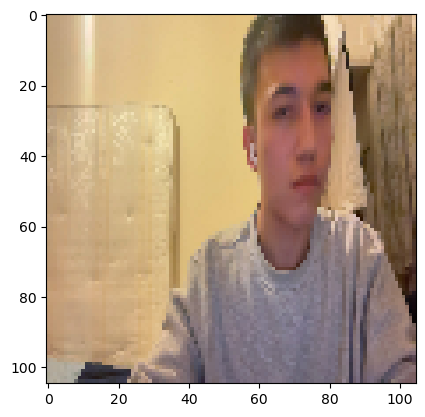

In [26]:
plt.imshow(img)

# 3.3 Create Labelled Dataset

In [27]:
# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0

In [28]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [29]:
data

<_ConcatenateDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [30]:
samples = data.as_numpy_iterator()

In [31]:
example = samples.next()

In [32]:
example

(b'data/anchor/6df160f8-82d9-11ee-be0a-c2215609a552.jpg',
 b'data/positive/232c7548-6eee-11ee-a243-c2215609a551.jpg',
 1.0)

# 3.4 Build Train and Test Partition

In [33]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [34]:
res = preprocess_twin(*example)

In [35]:
len(res)

3

In [36]:
#Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [37]:
#Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8) 

In [38]:
train_samples = train_data.as_numpy_iterator()

In [39]:
train_sample = train_samples.next()

In [40]:
round(len(data)*.3)

6

In [41]:
#Testing partition 
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# 4 Model Engineering

# 4.1 Build Embedding Layer

In [42]:
def make_embedding():
    inp = Input(shape=(105,105,3), name='input_image')
    
    #First block
    c1 = Conv2D(64, (10, 10), activation ='relu')(inp)
    m1 = MaxPooling2D(64,(2,2), padding='same')(c1)
    
    #Second block
    c2 = Conv2D(128, (7,7), activation ='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    #Third block
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    #Final emdbedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [43]:
inp = Input(shape=(105,105,3), name='input_image')

In [44]:
inp

<KerasTensor: shape=(None, 105, 105, 3) dtype=float32 (created by layer 'input_image')>

In [45]:
c1 = Conv2D(64, (10, 10), activation = 'relu')(inp)

In [46]:
c1

<KerasTensor: shape=(None, 96, 96, 64) dtype=float32 (created by layer 'conv2d')>

In [47]:
m1 = MaxPooling2D(64,(2,2), padding='same')(c1)

In [48]:
m1

<KerasTensor: shape=(None, 48, 48, 64) dtype=float32 (created by layer 'max_pooling2d')>

In [49]:
c2 = Conv2D(128, (7,7), activation ='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2) 

In [50]:
m2

<KerasTensor: shape=(None, 21, 21, 128) dtype=float32 (created by layer 'max_pooling2d_1')>

In [51]:
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

In [52]:
c3

<KerasTensor: shape=(None, 18, 18, 128) dtype=float32 (created by layer 'conv2d_2')>

In [53]:
m3

<KerasTensor: shape=(None, 9, 9, 128) dtype=float32 (created by layer 'max_pooling2d_2')>

In [54]:
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [55]:
c4

<KerasTensor: shape=(None, 6, 6, 256) dtype=float32 (created by layer 'conv2d_3')>

In [56]:
f1

<KerasTensor: shape=(None, 9216) dtype=float32 (created by layer 'flatten')>

In [57]:
d1

<KerasTensor: shape=(None, 4096) dtype=float32 (created by layer 'dense')>

In [58]:
embedding = make_embedding()

In [59]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 105, 105, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 96, 96, 64)        19264     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 48, 48, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 42, 42, 128)       401536    
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 21, 21, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 18, 18, 128)       26

 # 4.2 Build Custom Distance Layer

In [60]:
#Siamese L1 Distance class
class L1Dist(Layer):
    
    #Init method - inheritance
    def __init__(self, *kwargs):
        super().__init__()
        
    #Magic happens here - similarity calculation  
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

# 4.3 Make Siamese Model

In [61]:
def make_siamese_model():
    
    #Anchor image input in the network
    input_image = Input(name='input_img', shape=(105,105,3))
    
    #Validation image in the network
    validation_image = Input(name='validation_img', shape=(105,105,3))
    
    #Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name ='distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    #Classification layer
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs = classifier, name='SiameseNetwork')
    

In [62]:
input_image = Input(name='input_img', shape=(105,105,3))
validation_image = Input(name='validation_img', shape=(105,105,3))

In [63]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [64]:
siamese_layer = L1Dist()

In [65]:
distances = siamese_layer(inp_embedding, val_embedding)

In [66]:
classifier = Dense(1, activation='sigmoid')(distances)

In [67]:
classifier

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_2')>

In [68]:
siamese_network = Model(inputs=[input_image, validation_image], outputs = classifier, name='SiameseNetwork')

In [69]:
siamese_network.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 105, 105, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 105, 105, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

In [70]:
siamese_model = make_siamese_model()

In [71]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 105, 105, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 105, 105, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

# 5 Training

# 5.1 Setup Loss and Optimiser

In [72]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [73]:
opt = tf.keras.optimizers.legacy.Adam

In [74]:
opt

keras.src.optimizers.legacy.adam.Adam

# 5.2 Establish Checkpoints

In [75]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=Adam(), siamese_model=siamese_model)

# 5.3 Build Train Setup Function

In [76]:
test_batch = train_data.as_numpy_iterator()

In [77]:
batch = test_batch.next()

In [93]:
batch[2]

array([0., 0., 0., 1., 0., 1., 0., 1., 1., 1., 0., 0., 1., 1.],
      dtype=float32)

In [95]:
X = batch[:2]

In [96]:
batch

(array([[[[8.6896759e-01, 7.7484995e-01, 6.2583029e-01],
          [8.6666667e-01, 7.8039217e-01, 6.2745100e-01],
          [8.6358547e-01, 7.7731097e-01, 6.3221294e-01],
          ...,
          [8.4313726e-01, 8.2352942e-01, 7.4901962e-01],
          [8.4939951e-01, 8.2979167e-01, 7.5528187e-01],
          [8.5238099e-01, 8.3277315e-01, 7.5826335e-01]],
 
         [[8.6638659e-01, 7.7226889e-01, 6.2324929e-01],
          [8.6274511e-01, 7.7254903e-01, 6.1176473e-01],
          [8.7450981e-01, 7.8039217e-01, 6.3921571e-01],
          ...,
          [8.5154045e-01, 8.3193260e-01, 7.5742275e-01],
          [8.4285671e-01, 8.2324886e-01, 7.4873906e-01],
          [8.3893555e-01, 8.1932771e-01, 7.4481791e-01]],
 
         [[8.5490197e-01, 7.6470590e-01, 6.0392159e-01],
          [8.5882354e-01, 7.6470590e-01, 6.1568630e-01],
          [8.5164070e-01, 7.6536620e-01, 6.2026817e-01],
          ...,
          [8.4771889e-01, 8.2484978e-01, 7.6012379e-01],
          [8.4005600e-01, 8.2044816e-

In [99]:
y = batch[2]

In [100]:
y

array([0., 0., 0., 1., 0., 1., 0., 1., 1., 1., 0., 0., 1., 1.],
      dtype=float32)

In [91]:
tf.losses.BinaryCrossentropy??

In [92]:
# Instantiate the optimizer outside of tf.function
opt = tf.keras.optimizers.Adam()

@tf.function
def train_step(batch):
    with tf.GradientTape() as tape:
        # Forward pass
        X = batch[:2]
        y = batch[2]
        yhat = siamese_model(X, training=True)
        loss = binary_cross_loss(y, yhat)

    # Compute gradients
    grads = tape.gradient(loss, siamese_model.trainable_variables)

    # Pair gradients with variables
    grads_and_vars = list(zip(grads, siamese_model.trainable_variables))

    # Apply gradients using the optimizer instantiated outside tf.function
    opt.apply_gradients(grads_and_vars)

    # Ensure the optimizer state is updated
    opt.iterations.assign_add(1)

    return loss

# 5.4 Build Training Loop

In [101]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
                
        # Loop through each batch
        for idx, batch in enumerate(data):
            
            # Run train step here
            train_step(batch)
            progbar.update(idx+1)
            
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

# 5.5 Train the Model

In [102]:
EPOCHS = 50

In [103]:
train(train_data, EPOCHS)


 Epoch 1/50
1/1 [==============================] - 3s 3s/step

 Epoch 2/50
1/1 [==============================] - 3s 3s/step

 Epoch 3/50
1/1 [==============================] - 3s 3s/step

 Epoch 4/50
1/1 [==============================] - 3s 3s/step

 Epoch 5/50
1/1 [==============================] - 3s 3s/step

 Epoch 6/50
1/1 [==============================] - 3s 3s/step

 Epoch 7/50
1/1 [==============================] - 3s 3s/step

 Epoch 8/50
1/1 [==============================] - 3s 3s/step

 Epoch 9/50
1/1 [==============================] - 3s 3s/step

 Epoch 10/50
1/1 [==============================] - 3s 3s/step

 Epoch 11/50
1/1 [==============================] - 3s 3s/step

 Epoch 12/50
1/1 [==============================] - 3s 3s/step

 Epoch 13/50
1/1 [==============================] - 3s 3s/step

 Epoch 14/50
1/1 [==============================] - 3s 3s/step

 Epoch 15/50
1/1 [==============================] - 3s 3s/step

 Epoch 16/50
1/1 [==============================

# 6 Evaluate Model

# 6.1 Import Metrics

In [104]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

# 6.2 Make Predictions

In [105]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [106]:
test_var = test_data.as_numpy_iterator().next()

In [107]:
# Make predictions
y_hat = siamese_model.predict([test_input, test_val])
y_hat

1/1 [==============================] - 0s 391ms/step


array([[1.1918838e-04],
       [9.9995869e-01],
       [9.9998134e-01],
       [8.3331879e-06],
       [9.9998498e-01],
       [9.9999237e-01]], dtype=float32)

In [108]:
len(test_var[2])

6

In [109]:
# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[0, 1, 1, 0, 1, 1]

In [110]:
y_true

array([0., 1., 1., 0., 1., 1.], dtype=float32)

# 6.3 Calculate Metrics

In [111]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [112]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [113]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 

print(r.result().numpy(), p.result().numpy())

1/1 [==============================] - 0s 336ms/step
1.0 1.0


# 6.4 Visualise Results

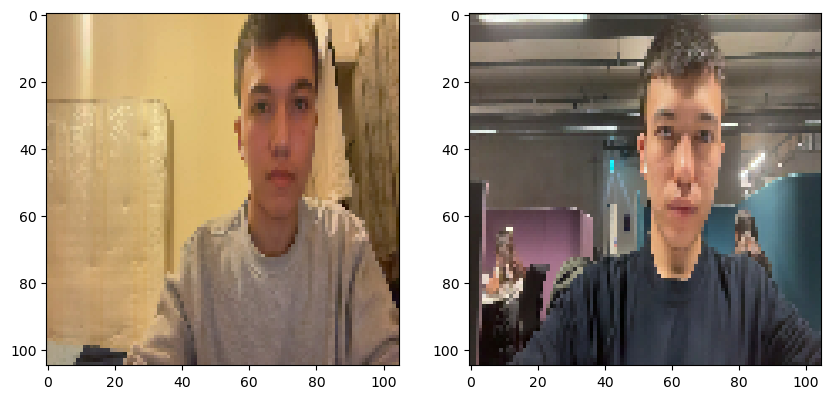

In [117]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[4])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[4])

# Renders cleanly
plt.show()

# 7 Save the Model

In [118]:
# Save weights
siamese_model.save('siamesemodel.h5')

/Applications/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [119]:
# Reload model 
siamese_model = tf.keras.models.load_model('siamesemodel.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [120]:
# Make predictions with reloaded model
siamese_model.predict([test_input, test_val])

1/1 [==============================] - 0s 414ms/step


array([[4.3815857e-05],
       [9.1308961e-05],
       [1.1918838e-04],
       [3.3044084e-06],
       [9.9961710e-01],
       [9.9998134e-01]], dtype=float32)

In [121]:
# View model summary
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 105, 105, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 105, 105, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

# 8 Real Time Test

# 8.1 Real Time Function

In [125]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []

    for image_file in os.listdir(os.path.join('application_data', 'verification_images')):
        # Skip directories
        if os.path.isdir(os.path.join('application_data', 'verification_images', image_file)):
            continue

        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image_file))

        # Make predictions
        result = model.predict([np.expand_dims(input_img, axis=0), np.expand_dims(validation_img, axis=0)])
        results.append(result)

    # Detection Threshold: Metric above which a prediction is considered positive
    detections = np.sum(np.array(results) > detection_threshold)

    # Verification Threshold: Proportion of positive predictions over verification images
    verification = detections / len(os.listdir(os.path.join('application_data', 'verification_images')))
    verified = verification > verification_threshold

    return results, verified

# 8.2 Open CV Real Time Verification

In [ ]:
cap = cv2.VideoCapture(0-0)
while cap.isOpened():
    ret, frame = cap.read()
    
    cv2.imshow('Verification', frame)
    
    #Verification trigger
    if cv2.waitKey(1) & 0xFF == ord('v'):
        #Save input image to input_image directory
        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        
        #Run verification
        results, verified = verify(siamese_model, 0.5, 0.5)
        print(verified)
    
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
        
    cap.release
    cv2.destroyAllWindows()

1/1 [==============================] - 0s 138ms/step
True
1/1 [==============================] - 0s 136ms/step
True
1/1 [==============================] - 0s 140ms/step
True
1/1 [==============================] - 0s 136ms/step
True
1/1 [==============================] - 0s 140ms/step
True
1/1 [==============================] - 0s 135ms/step


1/1 [==============================] - 0s 139ms/step
True
1/1 [==============================] - 0s 138ms/step
True
1/1 [==============================] - 0s 134ms/step
True
1/1 [==============================] - 0s 138ms/step
True
1/1 [==============================] - 0s 140ms/step
True
1/1 [==============================] - 0s 140ms/step
True
1/1 [==============================] - 0s 146ms/step


1/1 [==============================] - 0s 135ms/step
True
1/1 [==============================] - 0s 144ms/step
True
1/1 [==============================] - 0s 137ms/step
True
1/1 [==============================] - 0s 137ms/step
True
1/1 [==============================] - 0s 183ms/step
True


In [150]:
results

[array([[0.9990676]], dtype=float32),
 array([[0.99859554]], dtype=float32),
 array([[0.9985512]], dtype=float32),
 array([[0.9990669]], dtype=float32),
 array([[0.9992262]], dtype=float32),
 array([[0.99600327]], dtype=float32),
 array([[0.9242904]], dtype=float32),
 array([[0.99912214]], dtype=float32),
 array([[0.99829566]], dtype=float32),
 array([[0.99948597]], dtype=float32),
 array([[0.998716]], dtype=float32),
 array([[0.9977762]], dtype=float32),
 array([[0.760484]], dtype=float32),
 array([[0.99931103]], dtype=float32),
 array([[0.99934137]], dtype=float32),
 array([[0.99882686]], dtype=float32),
 array([[0.99892056]], dtype=float32),
 array([[0.99891436]], dtype=float32),
 array([[0.9982477]], dtype=float32),
 array([[0.10265335]], dtype=float32),
 array([[0.33342344]], dtype=float32),
 array([[0.9994879]], dtype=float32),
 array([[0.95764935]], dtype=float32),
 array([[0.9994408]], dtype=float32),
 array([[0.9996517]], dtype=float32),
 array([[0.9991101]], dtype=float32),
 